# 稳态转换的原因

In [1]:
# 加载必要的包
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.colors
import sys


plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'out'
sys.path.append("..")
period_colors = ['#0889A6', '#F1801F', '#006C43']

from matplotlib.gridspec import GridSpec
from tools.statistic import plot_pittitt_change_points


# 加载阈值为 0.05的数据，即与黄河流域相交面积大于全市总面积 5% 的所有市
city_yr = pd.read_csv(
    '../data/perfectures/yr/perfectures_in_YR_with_threshold_0.05.csv',
    index_col=0)

regions = city_yr['Region'].unique()
city_yr.shape
city_yr.head()

(2940, 59)

,Year,IRR,Irrigated area: Total,Irrigated area: Rice,Irrigated area: Wheat,Irrigated area: Maize,Irrigated area: Vegetables and fruits,Irrigated area: Others,Irrigation water-use intensity (WUI): Total,Irrigation water-use intensity (WUI): Rice,...,Rural domestic WUI,Rural livestock WU,Livestock population,Livestock WUI,Total water use,Province_n,Area_calcu,Region,Intersect_area,Ratio
City_ID,,,,,,,,,,,,,,,,,,,,,
C27,1965,0.300518,46.631997,0.391448,16.089679,1.152312,0.571298,28.427261,644.445209,965.436106,...,31.895556,0.003203,141.750766,0.022595,0.328586,Gansu,20091.467281,UR,19188.439369,0.955054
C27,1966,0.323595,49.468303,0.383836,16.485679,1.434736,0.636613,30.527440,654.146772,979.121070,...,28.371723,0.003336,147.646616,0.022592,0.351996,Gansu,20091.467281,UR,19188.439369,0.955054
C27,1967,0.340063,52.309331,0.416675,17.803304,1.442818,0.697033,31.949501,650.100439,973.012862,...,21.033715,0.003413,151.033245,0.022600,0.372432,Gansu,20091.467281,UR,19188.439369,0.955054
C27,1968,0.352690,53.870788,0.437429,18.863369,1.514685,0.770592,32.284713,654.695280,979.011409,...,22.233352,0.003487,154.266500,0.022604,0.391458,Gansu,20091.467281,UR,19188.439369,0.955054
C27,1969,0.365740,55.120730,0.447621,19.700679,1.549920,0.752680,32.669830,663.524461,992.248499,...,32.825618,0.003575,158.251492,0.022594,0.406136,Gansu,20091.467281,UR,19188.439369,0.955054


## 水库数据调用

In [2]:
reservoirs = pd.read_csv("../data/hydrology/clean_reservoirs.csv")
cum_reservoirs = pd.read_csv("../data/hydrology/cum_reservoirs.csv", index_col=0).cumsum().loc[1965: 2013]
reservoirs.head()
cum_reservoirs.head()

,年,容量,名称,省份,区域,枢纽
0,1958,40.000,东平湖围堤,山东省,DR,0
1,1959,2.160,盐锅峡,甘肃省,UR,1
2,1960,0.168,红领巾水库,河北省,DR,0
3,1961,7.230,汾河水库,山西省,MR,0
4,1962,2.570,巴家嘴水库,甘肃省,UR,0


,SR,UR,MR,DR
1965,0.0,4.73,7.23,113.368
1966,0.0,4.73,7.23,115.578
1967,0.0,12.08,7.23,115.578
1968,0.0,69.08,7.23,115.578
1969,0.0,69.08,7.23,115.578


/Users/songshgeo/opt/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/var/folders/m8/qpvn85g95rbgw5j_qb5g2pzh0000gn/T/ipykernel_12103/190579323.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  key_data['Eng_name'] = [


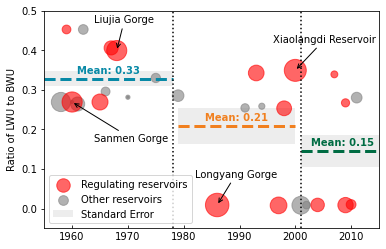

In [3]:
def get_region_wu(yr, region):
    region_wu = city_yr.groupby(['Region', 'Year']).sum()['Total water use'] * 10
    if yr in city_yr['Year'].unique():
        return region_wu[region][yr]
    elif yr <= 1965:
        return region_wu[region][1965]
    elif yr >= 2013:
        return region_wu[region][2013]


def get_all_wu(yr):
    wu = city_yr.groupby('Year')['Total water use'].sum() * 10
    if yr in city_yr['Year'].unique():
        return wu[yr]
    elif yr <= 1965:
        return wu[1965]
    elif yr >= 2013:
        return wu[2013]


def get_ratio_location(row):
    region = row['区域']
    yr = row['年']
    ratio = get_region_wu(yr, region) / get_all_wu(yr)
    return ratio 



fig, ax = plt.subplots()

def plot_reservoirs(ax):
    reservoirs['ratio'] = reservoirs.apply(get_ratio_location, axis=1)
    hubs = reservoirs[reservoirs['枢纽'] == 1]
    not_hubs = reservoirs[reservoirs['枢纽'] == 0]
    scale = 100
    alpha = 0.6
    ax.scatter(x=hubs['年'], y=hubs['ratio'], s=np.log(hubs['容量'])*scale, color='red', label='Regulating reservoirs', alpha=alpha, zorder=2)
    ax.scatter(x=not_hubs['年'], y=not_hubs['ratio'], s=np.log(not_hubs['容量'])*scale, color='gray', label='Other reservoirs', alpha=alpha, zorder=1)

#     ax.set_xlabel("Year")
    ax.set_ylabel("Ratio of LWU to BWU")

    # ========= 标注关键的水库 ========= #
    mask1 = reservoirs['枢纽'] == 1
    mask2 = reservoirs['容量'] > 20
    key_data = reservoirs[mask1 & mask2]
    key_data
    key_data['Eng_name'] = [
        "Liujia Gorge",
        "Longyang Gorge",
        "Sanmen Gorge",
        "Xiaolangdi Reservoir"
    ]

    for row in key_data.itertuples(index=False):
        yr = row[0]
        ratio = row[6]
        name = row[7]
        if name == 'Sanmen Gorge':
            ax.annotate(name,
                    xy=(yr, ratio), xycoords='data',
                    xytext=(yr+4, ratio-0.1), textcoords='data',
                    arrowprops=dict(arrowstyle="->",
                                    connectionstyle='arc3'))
        else:
            ax.annotate(name,
                    xy=(yr, ratio), xycoords='data',
                    xytext=(yr-4, ratio+0.07), textcoords='data',
                    arrowprops=dict(arrowstyle="->",
                                    connectionstyle='arc3'))

    # =========== 每个阶段的平均值 =========== #
    ax.set_xlim(1955, 2015)
    ax.set_ylim(-0.05, 0.5)
    periods = [(1955, 1978), (1979, 2000), (2001, 2016)]
    periods_ratio_dict = {}  # 用来储存结果，检验显著性
    for i, period in enumerate(periods):
        start, end = period
        x_min, x_max = ax.get_xlim()
        y_min, y_max = ax.get_ylim()

        def get_y_ratio(x):
            return (x-y_min)/(y_max-y_min)
        
        start_ratio, end_ratio = (start-x_min)/(x_max-x_min), (end-x_min)/(x_max-x_min)
        data = reservoirs[(reservoirs['年'] < end) & (reservoirs['年'] >= start)]
        ratio = data['ratio'].mean()
        std = data['ratio'].std() / np.sqrt(len(data))
        periods_ratio_dict["{}-{}".format(start, end)] = data['ratio'] 
        if i == 0:
            ax.axvspan(start, end, get_y_ratio(ratio-std), get_y_ratio(ratio+std), facecolor='lightgray', alpha=0.4, zorder=-1, label='Standard Error')
        else:
            ax.axvspan(start, end, get_y_ratio(ratio-std), get_y_ratio(ratio+std), facecolor='lightgray', alpha=0.4, zorder=-1)
        ax.axhline(ratio, start_ratio, end_ratio, ls="--", lw=3, color=period_colors[i])
        ax.text((start+end)/2, ratio+0.02, s="Mean: {:.2f}".format(ratio), color=period_colors[i], weight='bold', ha='center', va='center')

    # 阶段划分
    ax.axvline(x=1978, ls=":", lw=1.5, c='black')
    ax.axvline(x=2001, ls=":", lw=1.5, c='black')

    ax.legend(loc=3)
    return periods_ratio_dict

ratio_data = plot_reservoirs(ax)
plt.show();

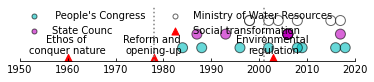

In [4]:
policy = pd.read_excel("../data/policy.xlsx")
def div_levels(x):
    if x == "National People's Congress of the PRC":
        return 3
    elif x == "State Council of the PRC":
        return 2
    elif x == "Ministry of Water Resources of the PRC":
        return 1

policy['level'] = policy['agency'].apply(div_levels)

events = pd.read_csv('../data/processed/big_events.csv', index_col=0)
frequency = events.groupby("Year").count()['Title'].loc[1950:2015]

def plot_time_line(ax=False):
    alpha=0.6
    if not ax:
        fig, ax = plt.subplots(figsize=(6, 1))
    
    colors = ['c', 'm', 'white']
    trans_color = 'red'
    scale = 100
    ys = [-0.5, 0, 0.5]
    # 每个层级的点分别绘图
    for i, level in enumerate(policy['level'].unique()):
        data = policy[policy['level'] == level]
        x = data['施行or修订时间'].values
        y = np.ones(len(x)) * ys[i]
        s = np.ones(len(x)) * scale
        ax.scatter(x, y, color=colors[i], s=s, edgecolor='black', label=data['agency'].iloc[0].strip('of the PRC').strip('National'), alpha=alpha)
        
    # dates = policy['施行or修订时间']
    # ax.plot(dates, np.zeros_like(dates), "-.", zorder=-1, color='lightgray')
    # ax.hlines(0.8, 1965, 1978, color=colors[i])
    transformation = ax.scatter(1960, -1, s=scale*2, color=trans_color, marker='^', label='Social transformation')
    
    ax.scatter(1978, -1, s=scale*2, color=trans_color, marker='^', zorder=1)
#     ax.scatter(1987, -1, s=scale*2, color=trans_color, marker='^', zorder=1)
    ax.scatter(2003, -1, s=scale*2, color=trans_color, marker='^', zorder=1)
    ax.text(1960, -0.8, "Ethos of \nconquer nature", horizontalalignment='center', verticalalignment='bottom')
    ax.text(1978, -0.8, "Reform and \nopening-up", horizontalalignment='center', verticalalignment='bottom')
    ax.text(2003, -0.8, "Environmental \nregulation", horizontalalignment='center', verticalalignment='bottom')

    ax.set_xlim(1950, 2020)
    ax.set_ylim(-1, 1)
    ax.set_yticks([])
    ax.axvline(1978, ls=':', color='gray')
    ax.axvline(2001, ls=':', color='gray')

    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.legend(loc='upper left',frameon=False,
            ncol=2, borderaxespad=0., markerscale=0.5)

plot_time_line()

/var/folders/m8/qpvn85g95rbgw5j_qb5g2pzh0000gn/T/ipykernel_12103/1030169143.py:5: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(wspace=0.3)
/var/folders/m8/qpvn85g95rbgw5j_qb5g2pzh0000gn/T/ipykernel_12103/190579323.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  key_data['Eng_name'] = [
/Users/songshgeo/opt/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


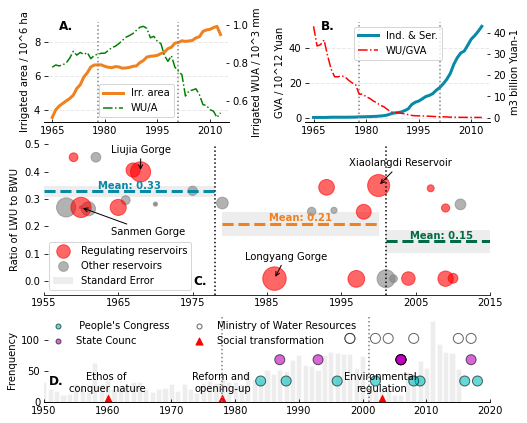

In [7]:
import seaborn as sns
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8, 7), constrained_layout=True)
fig.subplots_adjust(wspace=0.3)
gs = GridSpec(3, 3, figure=fig, height_ratios=[2, 3, 1.7], width_ratios=[1, 0.01, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, -1])
# ax3 = fig.add_subplot(gs[1, :3])
ax4 = fig.add_subplot(gs[1, :])
ax5 = fig.add_subplot(gs[2, :])
ax6 = ax5.twinx()

gva_cols = ['Irrigated area: Total', 'Industrial gross value added (GVA): Total', "Service GVA"]
wui_cols = ['Irrigation water-use intensity (WUI): Total', 'Industrial WUI: Total', 'Service WUI']

size = 50  # 图1 和 图2 散点的大小
alpha = 0.2  # 图1 和 图2 散点的透明度

# 图1： =========================== 农业发展 ==================================

irrigation_area = ax1.plot(
    city_yr.groupby(['Year']).sum()['Irrigated area: Total']/1000,
    color=period_colors[1],
    lw=3,
    label='Irr. area'
)

# 农业WUI
ax1_2 = ax1.twinx()
irrigation_wui = ax1_2.plot(
    city_yr.groupby(['Year']).mean()['Irrigation water-use intensity (WUI): Total']/1000, 
    ls="-.", 
    color='green', 
    label='WU/A',
)

# ax1.set_xlabel("Year")
ax1.set_ylabel("Irrigated area / 10^6 ha")
ax1_2.set_ylabel("Irrigated WUA / 10^3 mm")


# 图2： =========================== 工业服务业 ===================================
wui_mean = city_yr.groupby(['Year']).sum()[wui_cols]


industry = ax2.plot(
    city_yr.groupby(['Year']).sum()[['Industrial gross value added (GVA): Total', "Service GVA"]].sum(axis=1)/100,
    color=period_colors[0],
    lw=3,
    label='Ind. & Ser.'
)
ax2_2 = ax2.twinx()
mean_wui = ax2_2.plot(wui_mean.iloc[:, 1:].mean(axis=1), "-.", color='red', label="WU/GVA")

# ax2.set_xlabel("Year")
ax2.set_ylabel("GVA / 10^12 Yuan")
ax2_2.set_ylabel("m3 billion Yuan-1")
  
# ======= 图4 =========
plot_reservoirs(ax4)

# ======= 图5 =========
frequency = events.groupby("Year").count()['Title'].loc[1950:2015]
ax5.bar(frequency.index, frequency.values, color='lightgray', edgecolor='white', zorder=0, alpha=0.4)
plot_time_line(ax6)

# 修饰图片 ============
ax1.legend(handles=irrigation_area+irrigation_wui, loc='lower center')
ax2.legend(handles=industry+mean_wui, loc='upper center')
ax4.legend()

# 标签
from tools.processing import get_position_by_ratio
import matplotlib.ticker as ticker

x_r, y_r = 0.12, 0.95
x1, y1 = get_position_by_ratio(ax1, x_r, y_r)
x2, y2 = get_position_by_ratio(ax2, x_r, y_r)
ax1.text(x1, y1, 'A.', ha='center', va='center', weight='bold', size='large')
ax2.text(x2, y2, 'B.', ha='center', va='center', weight='bold', size='large')
# ax3.text(-0.2, 20, 'c.', ha='center', va='center', weight='bold', size='large')
ax4.text(1976, 0.0, 'C.', ha='center', va='center', weight='bold', size='large')
ax6.text(1952, -0.5, 'D.', ha='center', va='center', weight='bold', size='large')

# 坐标轴
plt.rcParams['xtick.direction'] = 'in'  # in; out; inout
plt.rcParams['ytick.direction'] = 'in'
ax1.axes.get_xaxis().set_visible(True)
for ax in [ax1, ax2]:
    ax.axvline(1978, ls=':', color='gray', lw=1.5)
    ax.axvline(2001, ls=':', color='gray', lw=1.5)
    ax.yaxis.grid(color='lightgray', linestyle='-.', linewidth=0.5)

for ax in [ax1, ax2, ax1_2, ax2_2, ax4, ax5, ax6]:
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)

for ax in [ax1, ax2, ax1_2, ax2_2]:
    ax.set_xticks(np.arange(1965, 2013, 15))

ax4.set_xticks(np.arange(1955, 2016, 10))
ax5.set_ylabel("Frenquency")
# ax6.set_ylabel("Level")

# 储存和显示图片
plt.savefig('../figures/main/causes.pdf', dpi=300)
plt.savefig('../figures/main/causes.jpg', dpi=300)
plt.show();